<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/JAX_jaxopt_optax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install -q jaxopt
! pip install -q optax
! pip install -q corner

In [3]:
import jax
import jax.numpy as jnp
import jax.scipy as jsc

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian

import numpy as np

import jaxopt
import optax

jax.config.update("jax_enable_x64", True)

import matplotlib as mpl
from matplotlib import pyplot as plt

import corner
import arviz as az
mpl.rcParams['font.size'] = 20


# Theme: `jaxopt`/`optax` optmization lib. ([doc](https://jaxopt.github.io/stable/index.html))"
   

## 1st exemple

$$
f(t) = R_0 + v t - \Theta(t)\times k(1-e^{t/\tau})\qquad with \quad \Theta(t) = 1 (t>=0), 0 (t < 0)
$$

We will generate noisy data (forward modeling) and then we will perform inference (estimation).


In [4]:
def mean_fn(x, params):
    """Parametrisation avant et apres (t=0) """
    R0 = params["R0"]
    v  = params["v"]
    k  = params["k"]
    tau =  params["tau"]
    return jnp.where(x < 0, R0 + v*x, R0 + v*x - k*(1.-jnp.exp(-x/tau)))


In [5]:
par_true={"R0":35.0, "v":2.20, "k":15.5, "tau": 1.0}
sigma_obs=1.0


In [6]:
#Random gene
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)

In [7]:
tMes = jax.random.uniform(rng_key0,minval=-5.,maxval=5.0,shape=(20,))
tMes=jnp.append(tMes,0.0)
tMes=jnp.sort(tMes)

In [8]:
RMes = mean_fn(tMes,par_true) + sigma_obs * jax.random.normal(rng_key1,shape=tMes.shape)

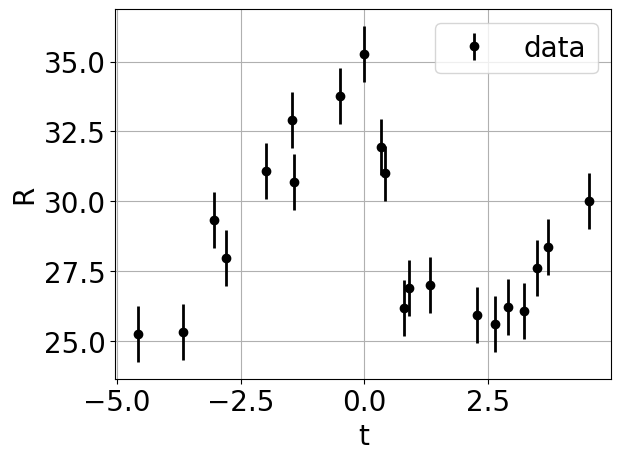

In [9]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

We fix a Gaussian likelihood (log-likelihood quadratic) residuals normalized by the measurement error

In [10]:
def lik(p,t,R, sigma_obs=1.0):
    params = {"R0":p[0], "v":p[1], "k":p[2], "tau": p[3]}
    resid = mean_fn(t, params)-R
    return 0.5*jnp.sum((resid/sigma_obs) ** 2)


In [11]:
def get_infos(res, model, t,R):
    params    = res.params
    fun_min   = model(params,t,R)
    jacob_min =jax.jacfwd(model)(params, t,R)
    inv_hessian_min =jax.scipy.linalg.inv(jax.hessian(model)(params, t,R))
    return params,fun_min,jacob_min,inv_hessian_min


## Jaxopt: GradientDescent

Instead of doing a gradient descent by hand we use the jaxopt library: GradientDescent, optax solver, ScipyWrapper.

In [12]:
gd = jaxopt.GradientDescent(fun=lik, maxiter=1000)
init_params = jnp.array([18.,1.,10.,1.])
res = gd.run(init_params,t=tMes, R=RMes)


In [13]:
params,fun_min,jacob_min,inv_hessian_min = get_infos(res, lik, t=tMes,R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)


params: [35.36653916  2.37454654 16.60209238  0.93105711] 
fun@min: 6.710336848470304 
jacob@min: [0.00425324 0.00190545 0.01147151 0.00063112] 
 invH@min: [[ 0.30761279  0.09638547  0.63828082 -0.00408842]
 [ 0.09638547  0.04649469  0.26423637  0.00267717]
 [ 0.63828082  0.26423637  1.84159393  0.04459909]
 [-0.00408842  0.00267717  0.04459909  0.01114583]]


## Optax Adam

In [14]:
opt = optax.adam(0.1)
solver = jaxopt.OptaxSolver(opt=opt, fun=lik, maxiter=10000)
init_params = jnp.array([18.,1.,10.,1.])
res = solver.run(init_params,t=tMes, R=RMes)


In [15]:
params,fun_min,jacob_min,inv_hessian_min = get_infos(res, lik, t=tMes,R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)


params: [35.35713338  2.37079478 16.57621824  0.93053084] 
fun@min: 6.710175452733027 
jacob@min: [-8.36101782e-04 -6.19403716e-05 -5.18760572e-04 -1.48194416e-05] 
 invH@min: [[ 0.30761646  0.09638606  0.63829251 -0.00407304]
 [ 0.09638606  0.04649234  0.26419596  0.00268056]
 [ 0.63829251  0.26419596  1.84090073  0.04456931]
 [-0.00407304  0.00268056  0.04456931  0.01114789]]


## JaxOpt: ScipyMinimize

In [16]:
minimizer = jaxopt.ScipyMinimize(fun=lik,method='BFGS',options={'gtol': 1e-6,'disp': False})
init_params = jnp.array([18.,1.,10.,1.])
res1 = minimizer.run(init_params, t=tMes, R=RMes)
params,fun_min,jacob_min,inv_hessian_min = get_infos(res1, lik, t=tMes,R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)


params: [35.35772761  2.37101534 16.57772394  0.93055088] 
fun@min: 6.710174806788167 
jacob@min: [-4.49239437e-08 -2.15598970e-08  2.22663490e-08 -9.25418149e-08] 
 invH@min: [[ 0.30761634  0.09638602  0.63829182 -0.00407356]
 [ 0.09638602  0.04649244  0.26419768  0.00268039]
 [ 0.63829182  0.26419768  1.84093013  0.04456978]
 [-0.00407356  0.00268039  0.04456978  0.0111473 ]]


## JaxOpt with Bounds

In [17]:
lbfgsb = jaxopt.ScipyBoundedMinimize(fun=lik, method="L-BFGS-B")
init_params = jnp.array([18.,1.,10.,1.])
res2 = lbfgsb.run(init_params, bounds=([10.,0.,0.,0.1],[100.,10.,50.,10.]),
                 t=tMes, R=RMes)
params,fun_min,jacob_min,inv_hessian_min = get_infos(res2, lik, t=tMes, R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)


params: [35.35772729  2.37101488 16.57771912  0.93055001] 
fun@min: 6.710174806823513 
jacob@min: [-3.02633377e-06 -7.62787971e-06  1.56824331e-06 -8.41643260e-05] 
 invH@min: [[ 0.30761632  0.09638602  0.63829193 -0.00407349]
 [ 0.09638602  0.04649244  0.26419771  0.00268041]
 [ 0.63829193  0.26419771  1.84092994  0.04456978]
 [-0.00407349  0.00268041  0.04456978  0.01114726]]


## Loss landscape

We'll take advantage of the auto-diff to plot the loss-landscape

In [20]:
def plot_landscape(ax,model,xdata,ydata, par_min, idx=(0,1), bounds=(0.,1.,0.,1.), model_args=(), model_kwargs={}):
    xmin,xmax,ymin,ymax = bounds
    grid = x0,y0 = jnp.mgrid[xmin:xmax:101j,ymin:ymax:101j]

    pts = jnp.swapaxes(grid,0,-1).reshape(-1,2)
    points = jnp.repeat(par_min[None, :], pts.shape[0], axis=0)
    for i in (0,1):
        points = points.at[:,idx[i]].set(pts[:,i])

    vfunc = jit(vmap(lambda p,x,y: model(p,x,y,*model_args, **model_kwargs), in_axes = (0,None,None)))
    v = vfunc(points,xdata,ydata)
    v = jnp.swapaxes(v.reshape(101,101),0,-1)
    g0=ax.contourf(x0,y0,v, levels = 100)
    ax.contour(x0,y0,v, levels = 50, colors = 'w')

    grid = jnp.mgrid[xmin:xmax:10j,ymin:ymax:10j]
    pts = jnp.swapaxes(grid,0,-1).reshape(-1,2)
    points = jnp.repeat(par_min[None, :], pts.shape[0], axis=0)
    for i in (0,1):
        points = points.at[:,idx[i]].set(pts[:,i])

    gradients = jit(vmap(
        grad(
            lambda p,x,y: model(p,x,y, *model_args, **model_kwargs)
        ), in_axes = (0,None,None)
    ))(points,xdata,ydata)

    scale = int(0.2*np.max(gradients))
    ax.quiver(
        points[:,idx[0]],
        points[:,idx[1]],
        gradients[:,idx[0]],
        gradients[:,idx[1]],
        color="white",
        angles = 'xy',
        scale_units='xy',
        scale = scale
    )
    ax.set_aspect("equal")
    fig.colorbar(g0,ax=ax,shrink=0.5)

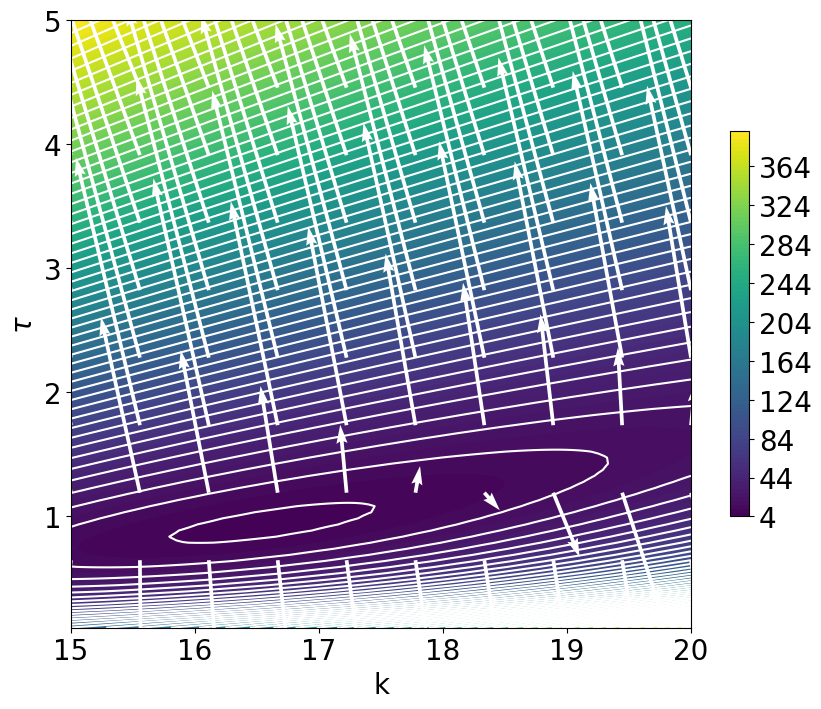

In [21]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_landscape(ax,model=lik,xdata=tMes,ydata=RMes,par_min=params, idx=(2,3),bounds=(15,20.,0.1,5.))
plt.xlabel("k")
plt.ylabel(r"$\tau$")
plt.show()


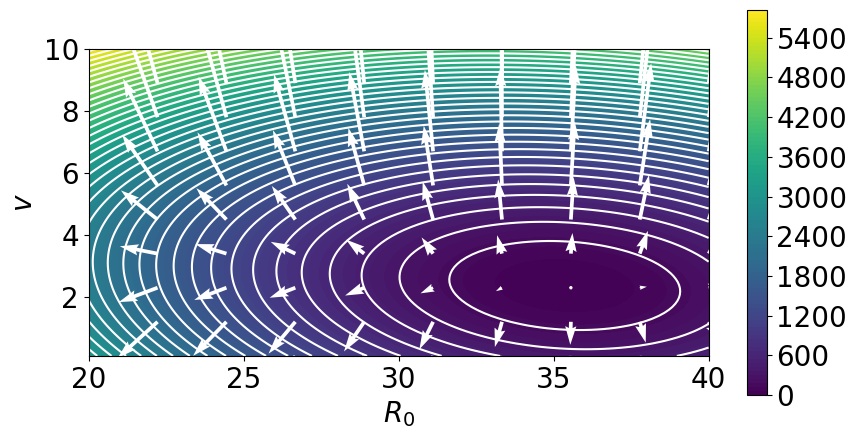

In [22]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_landscape(ax,model=lik,xdata=tMes,ydata=RMes,par_min=params, idx=(0,1),bounds=(20,40.,0.1,10.))
plt.xlabel(r"$R_0$")
plt.ylabel(r"$v$")
plt.show()


## Prediction/error bands: how to make a sampling from the Hessian

In [24]:
t_val = np.linspace(-5,5,100)
Rtrue_val = mean_fn(t_val,par_true)
param_spls = jax.random.multivariate_normal(rng_key2,mean=params,cov=inv_hessian_min,shape=(5000,))

func = jax.jit(jax.vmap(lambda x: mean_fn(t_val,{"R0":x[0],"v":x[1],"k":x[2],"tau":x[3]})))
Rall_val= func(param_spls)

Rmean_val = jnp.mean(Rall_val,axis=0)
std_R_val = jnp.std(Rall_val,axis=0)


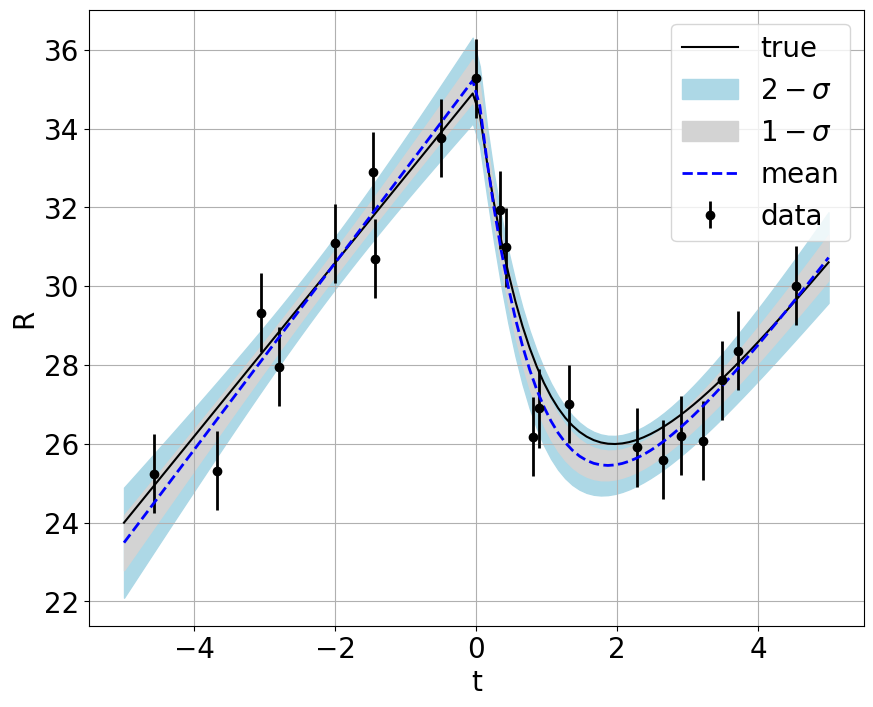

In [25]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val, Rmean_val-2*std_R_val, Rmean_val+2*std_R_val,
                    color="lightblue",label=r"$2-\sigma$")
plt.fill_between(t_val, Rmean_val-std_R_val, Rmean_val+std_R_val,
                    color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, Rmean_val, "blue", ls="--", lw=2.0, label="mean")


plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

Study of tmin (minimum) for $t>0$:
$$
t_{min} = \tau \times \log \frac{k}{v\tau}
$$

In [26]:
#R0,v,k,tau
par_min = params
par_min


Array([35.35772729,  2.37101488, 16.57771912,  0.93055001], dtype=float64)

In [27]:
inv_hessian_min

Array([[ 0.30761632,  0.09638602,  0.63829193, -0.00407349],
       [ 0.09638602,  0.04649244,  0.26419771,  0.00268041],
       [ 0.63829193,  0.26419771,  1.84092994,  0.04456978],
       [-0.00407349,  0.00268041,  0.04456978,  0.01114726]],      dtype=float64)

In [28]:
rgn_key, new_key = jax.random.split(rng_key)
samples = jax.random.multivariate_normal(new_key, mean=par_min, cov=inv_hessian_min, shape=(5000,))
samples = samples.T

In [29]:
def tmin(par):
    #par: R0,v,k,tau
    return par[3]*jnp.log(par[2]/par[3]/par[1])


In [30]:
tmins = tmin(samples)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


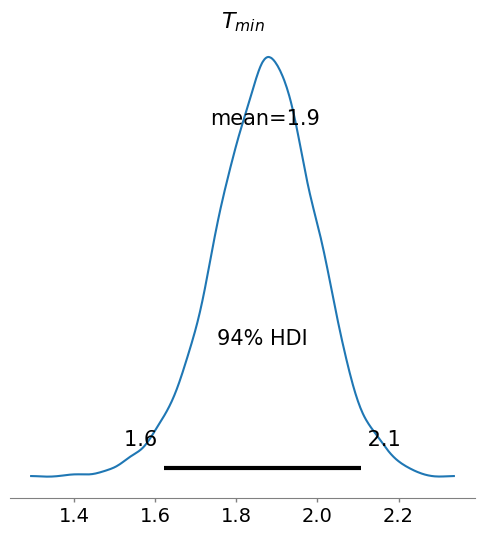

In [31]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
az.plot_posterior({"$T_{min}$":tmins},point_estimate='mean',ax=ax);


Contours plots: Fisher forecast
$$
F_{i,j} = \sum_{t:t_{mes}} \left.\frac{1}{\sigma^2} \frac{∂ f(p,t)}{∂ p_i}\right|_{p=p_{true}} \left.\frac{∂ f(p,t)}{∂ p_j}\right|_{p=p_{true}}
$$

In [32]:
def f(p):
    par = {"R0":p[0], "v":p[1], "k":p[2], "tau":p[3]}
    return mean_fn(tMes,par)


In [33]:
p_true = np.fromiter(par_true.values(), dtype=float)
p_true

array([35. ,  2.2, 15.5,  1. ])

In [34]:
jac = jax.jacfwd(f)(p_true)

In [35]:
cov_inv = np.zeros((jac.shape[0],jac.shape[0]))
di = np.diag_indices(cov_inv.shape[0])
cov_inv[di]=1./sigma_obs**2


In [36]:
F = jnp.einsum('ia,ij,jb',jac,cov_inv,jac)
F = 0.5*(F+F.T)


In [37]:
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, inds, nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """

  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[inds][::,inds]
  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  ellip = Ellipse(xy=pos[inds], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[inds[0]] - s1, pos[inds[0]] + s1)
  ax.set_ylim(pos[inds[1]] - s2, pos[inds[1]] + s2)
  plt.draw()
  return ellip


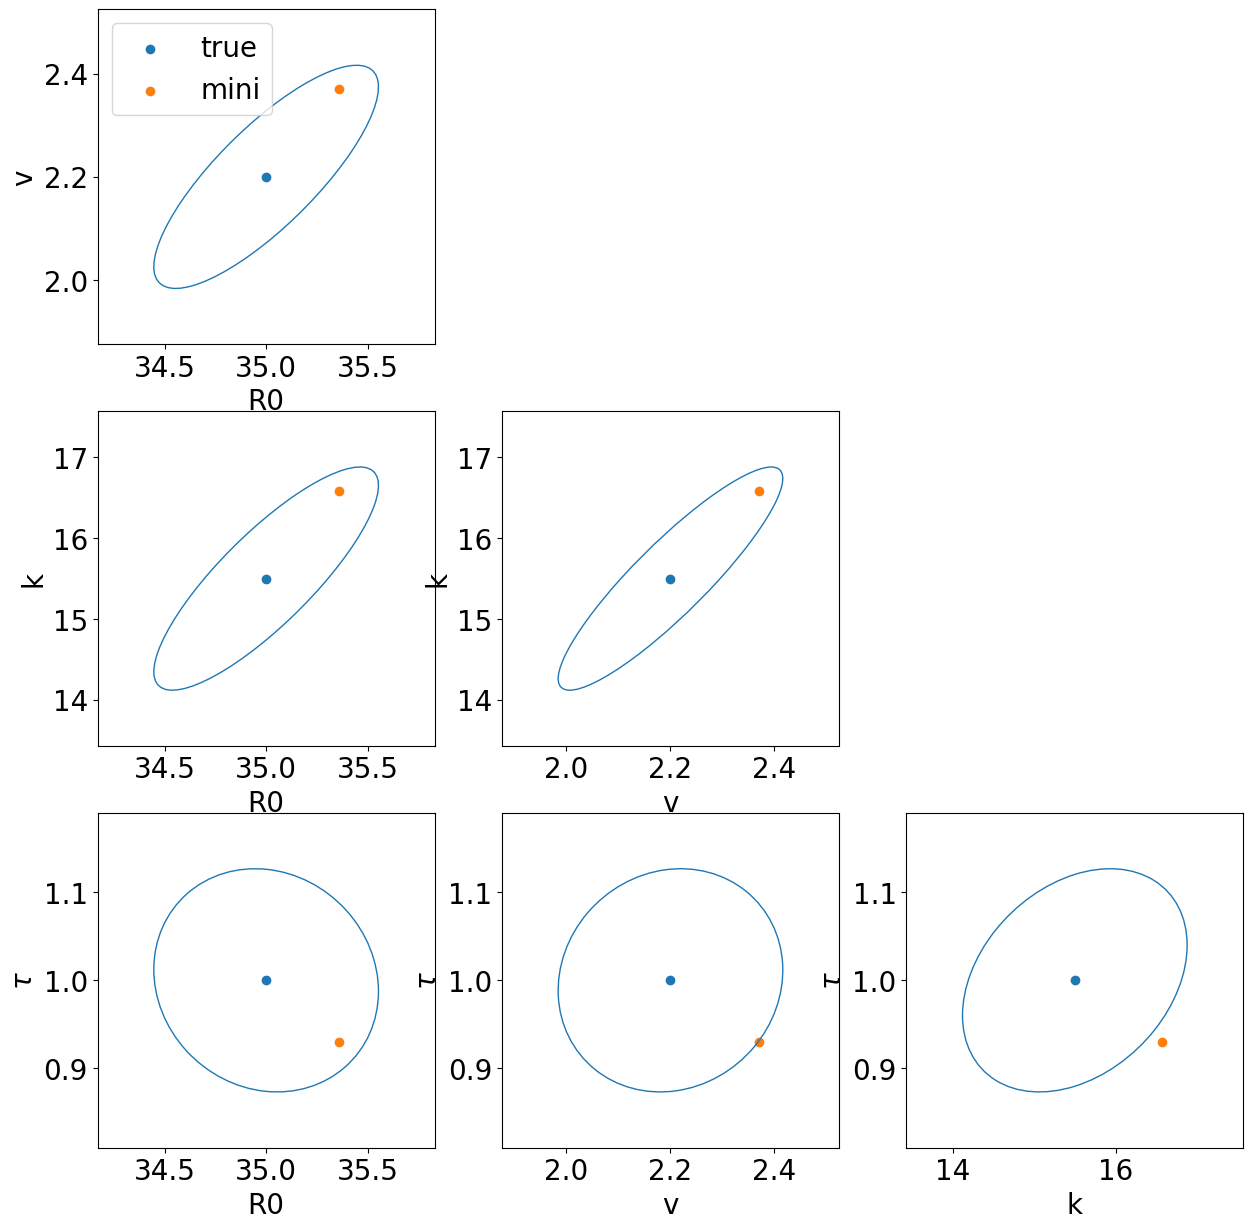

In [38]:
npar = p_true.shape[0]
pname = ["R0","v","k",r"$\tau$"]
plt.figure(figsize=(20, 20))
for i in range(1,npar):
    for j in range(npar):
        if j<i:
            plt.subplot(npar,npar,i*npar+j+1)
            plt.scatter(p_true[j],p_true[i], label="true")
            plt.scatter(par_min[j],par_min[i], label="mini")
            plt.xlabel(pname[j])
            plt.ylabel(pname[i])
            plot_contours(F, p_true, [j,i],fill=False,color='C0')
            if j==0 and i==1: plt.legend()

In [39]:
import arviz as az
import corner


In [40]:
data = {"R0":param_spls[:,0], "v":param_spls[:,1],"k":param_spls[:,2],"tau":param_spls[:,3]}


In [41]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map={"R0": r"$R_0$",
                                         "v":r"$v$",
                                         "k":r"$k$",
                                         "tau":r"$\tau$"})


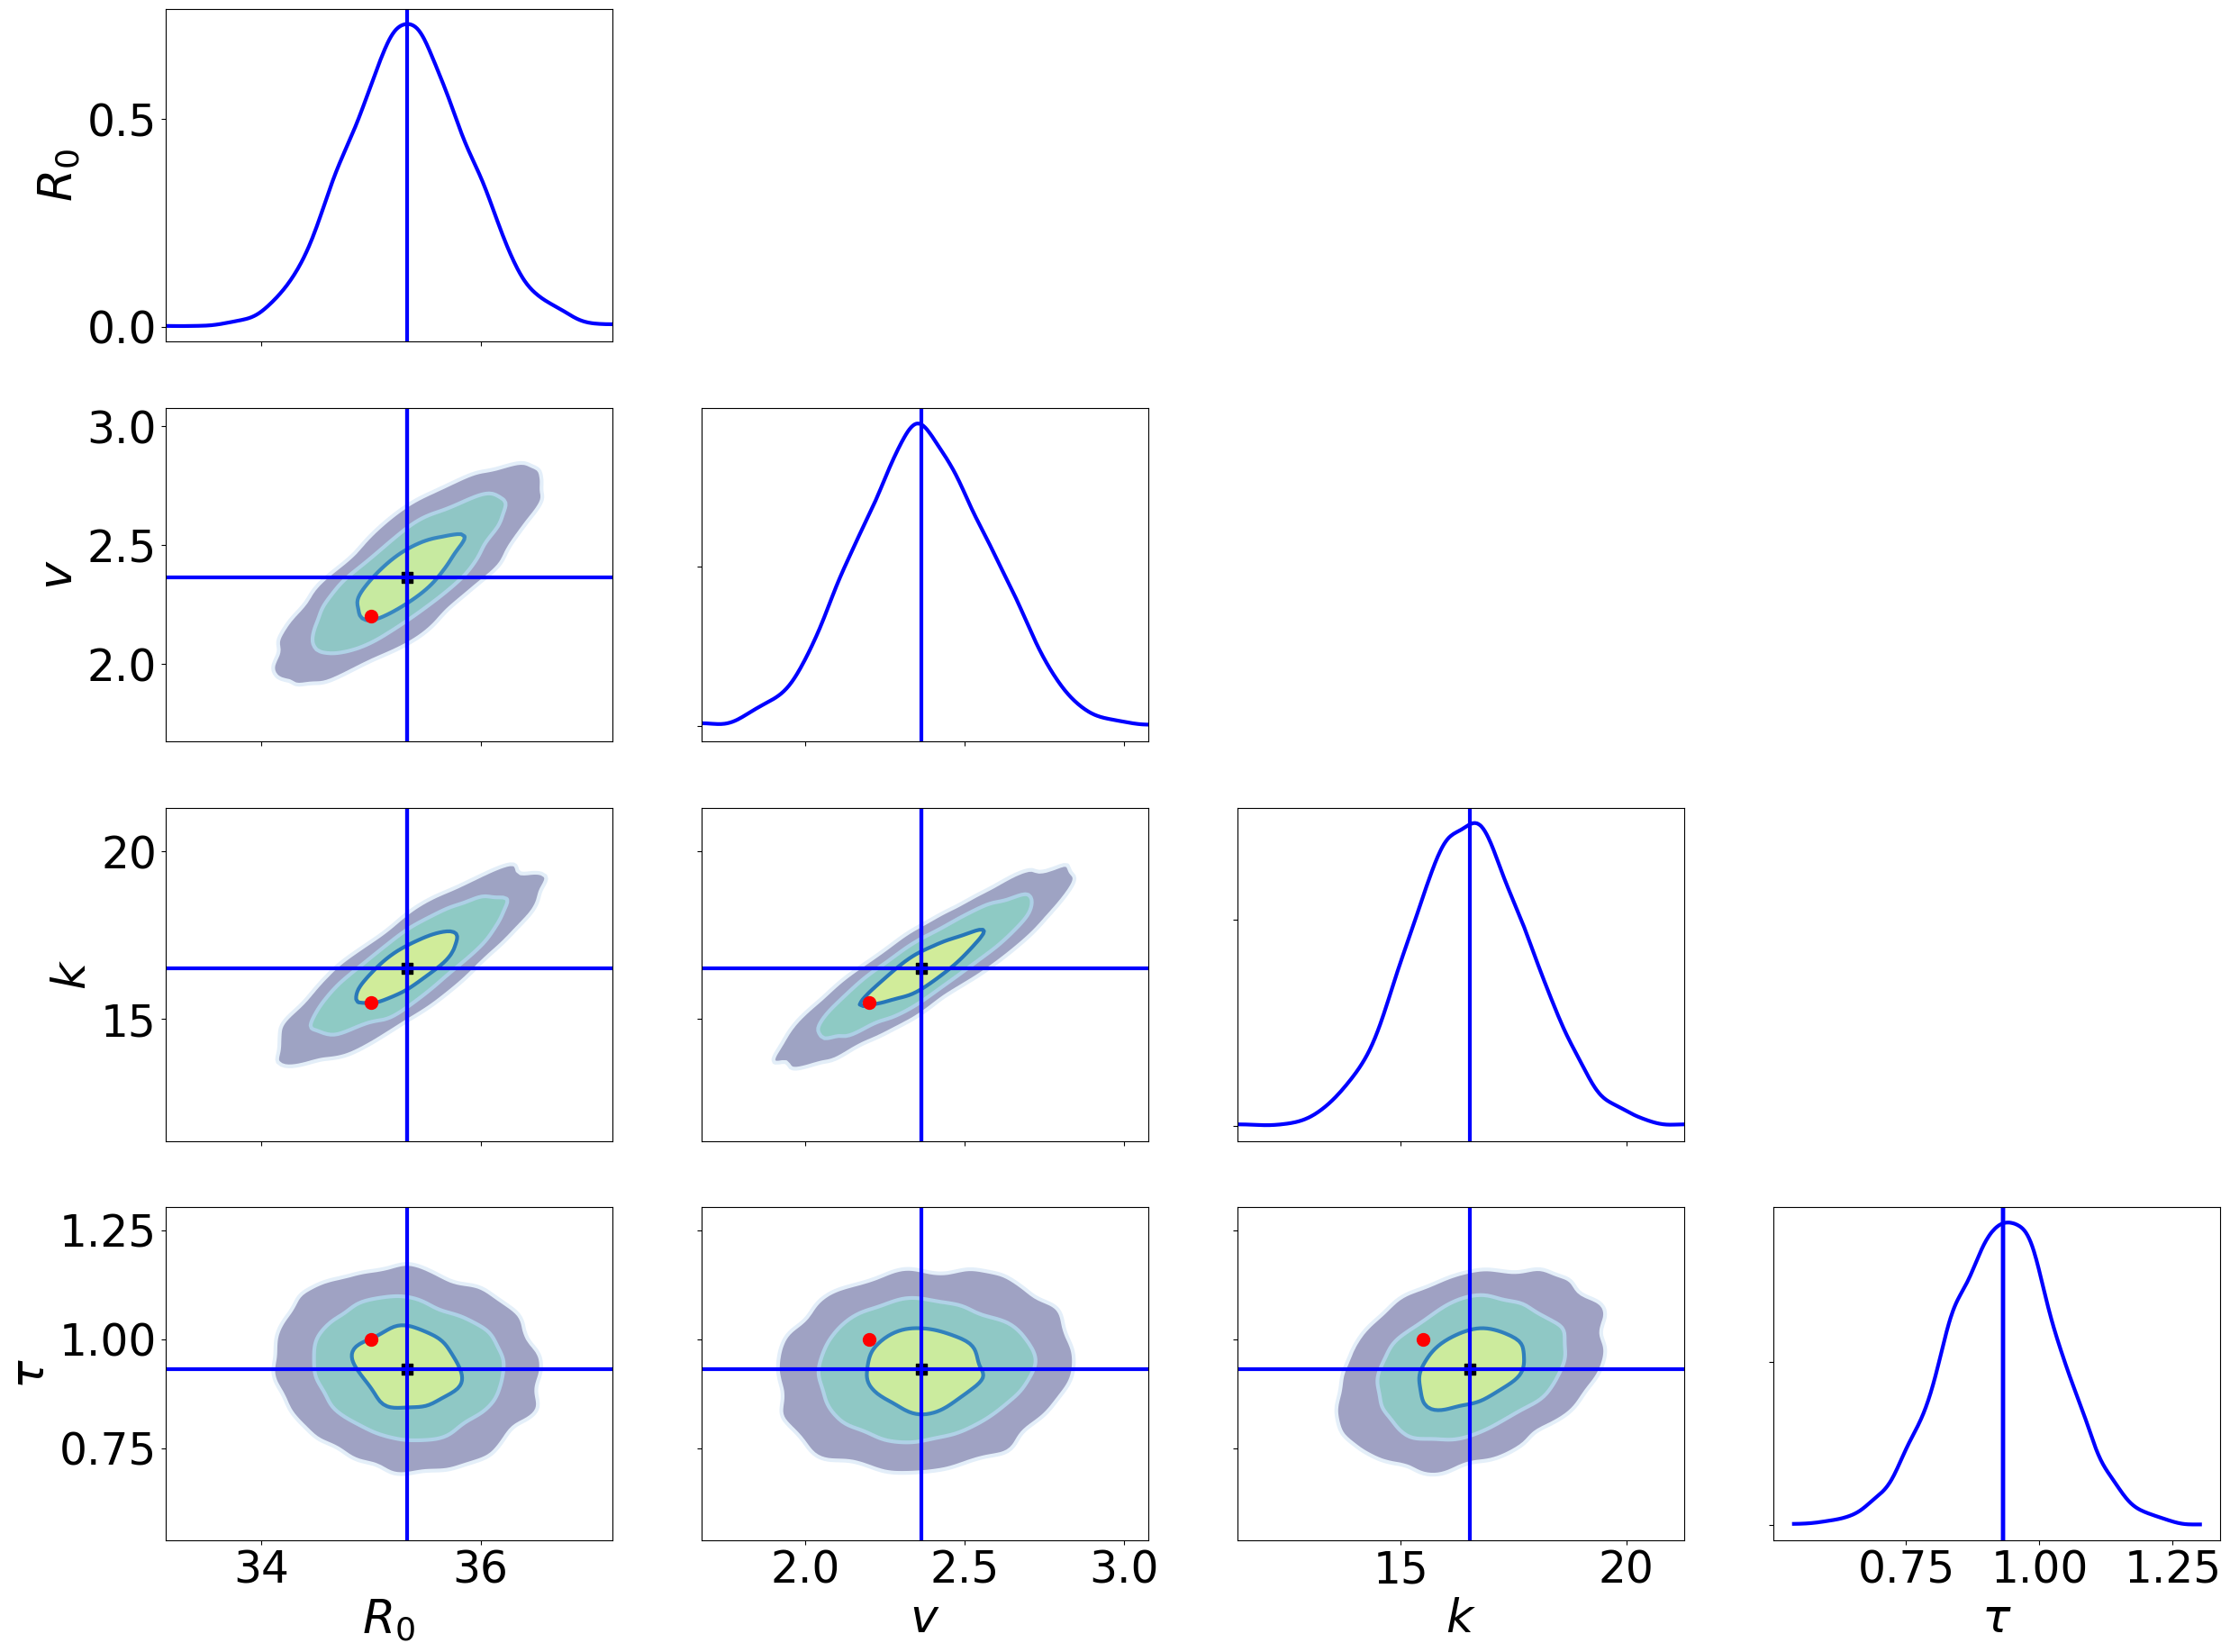

In [42]:
ax=az.plot_pair(
        data,
        kind="kde",
        labeller=labeller,
        marginal_kwargs={"plot_kwargs": {"lw":3, "c":"blue", "ls":"-"}},
        kde_kwargs={
            "hdi_probs": [0.3, 0.68, 0.9],  # Plot 30%, 68% and 90% HDI contours
            "contour_kwargs":{"colors":None, "cmap":"Blues", "linewidths":3,
                              "linestyles":"-"},
            "contourf_kwargs":{"alpha":0.5},
        },
        point_estimate_kwargs={"lw": 3, "c": "b"},
        marginals=True, textsize=35, point_estimate='median',
    );

ax[1,0].scatter(par_true["R0"],par_true["v"],c="r",s=100,zorder=10)
ax[2,0].scatter(par_true["R0"],par_true["k"],c="r",s=100,zorder=10)
ax[2,1].scatter(par_true["v"],par_true["k"],c="r",s=100,zorder=10)
ax[3,0].scatter(par_true["R0"],par_true["tau"],c="r",s=100,zorder=10)
ax[3,1].scatter(par_true["v"],par_true["tau"],c="r",s=100,zorder=10)
ax[3,2].scatter(par_true["k"],par_true["tau"],c="r",s=100,zorder=10)


# Minimization with constraint

In [43]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_l2_ball, projection_box, projection_l1_ball, projection_polyhedron
import scipy as sc

Find the lowest point on the intersection of a horse saddle and a cylinder.

In [46]:
#horse saddle : z = x^2-y^2
def f(x):
    return x[0]**2-x[1]**2
#cylinder: center on the z=0 plane at (xc,yc)=(-1,1) and radius r
def constraint(x,r):
    return jnp.atleast_1d(r**2 -((x[0]+1)**2 + (x[1]-1)**2))  # this should be 0 if constraint satisfied

In [47]:
#with scipy
r=1.5
sc.optimize.minimize(f, np.array([1, 1]), bounds=((-3, 3), (-3, 3)), method='SLSQP',
         constraints={"fun": constraint, "type": "ineq", 'args': (r,)})

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -5.623512131018319
       x: [-6.280e-01  2.453e+00]
     nit: 8
     jac: [-1.256e+00 -4.906e+00]
    nfev: 27
    njev: 8

In [49]:
# JaxOpt
def myproj1(x, hyper_params):
    radius = hyper_params   # this is the radius indeed
    center = jnp.array([1,-1])
    x = projection_l2_ball(x + center, radius) - center
    return x

Text(0, 0.5, 'Y')

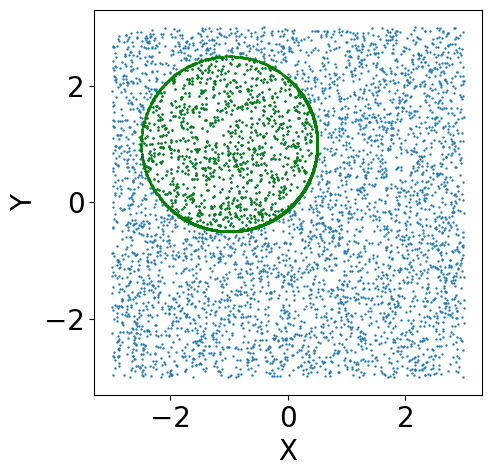

In [50]:
# Have a look at the (x,y) coordinates of point inside/outside the cylinder
rng_key = jax.random.PRNGKey(42)
r=1.5
x = jax.random.uniform(rng_key, (5000,2), minval=-3,maxval=3)
p1_x=jax.vmap(myproj1, in_axes=(0,None))(x,r)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x[:,0],x[:,1],s=0.5)
ax.scatter(p1_x[:,0],p1_x[:,1],s=0.5,c='g')
ax.set_xlabel("X")
ax.set_ylabel("Y")

In [51]:
pg=jaxopt.ProjectedGradient(fun=f,projection=myproj1)#, maxiter=1000, maxls=500)
res = pg.run(init_params=jnp.array([-1.,1.]), hyperparams_proj=r)
print(res.params, "\n", res.state)



[-0.62797252  2.45313301] 
 ProxGradState(iter_num=Array(6, dtype=int64, weak_type=True), stepsize=Array(1., dtype=float64), error=Array(0.00026464, dtype=float64), aux=None, velocity=Array([-0.62780615,  2.45309043], dtype=float64), t=Array(4.36507872, dtype=float64, weak_type=True))


In [53]:
constraint(res.params,r) # expect constraint = 0

Array([-8.8817842e-16], dtype=float64)

<ipython-input-54-0637ceaf8878>:30: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


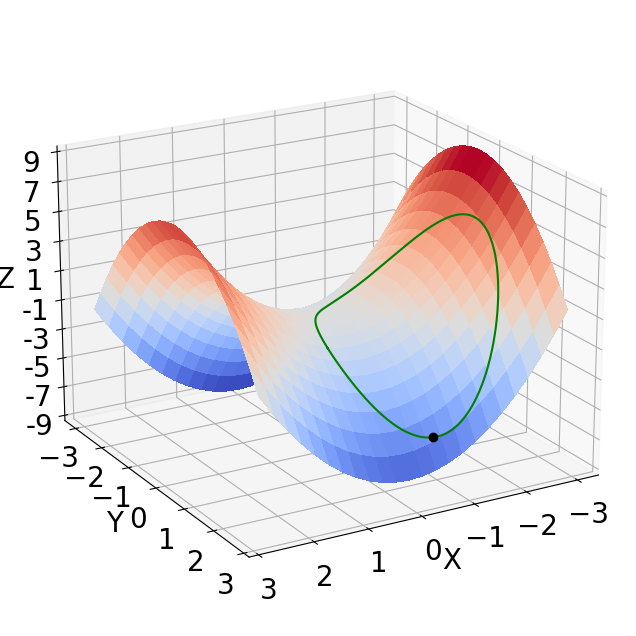

In [54]:
# 3D plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))

# Make data.
X = np.arange(-3, 3, 0.25)
Y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X**2-Y**2

# Make the image of the unit circle
r,xc,yc=1.5,-1.0,1.0
omega = np.linspace(0, 2*np.pi, 2048)
circ_X = r*np.cos(omega)+xc
circ_Y = r*np.sin(omega)+yc
circ_Z = circ_X**2 - circ_Y**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
circ = ax.plot(circ_X, circ_Y, circ_Z, color='green',zorder=3)

p_x = res.params[0]
p_y = res.params[1]
p_z = p_x**2 - p_y**2
ax.plot(p_x,p_y,p_z, 'ko', zorder=4)

ax.azim = 60
ax.dist = 10
ax.elev = 20


# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.0f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Method with Root Finding...

Find the biggest 3D box with a surface constraint: Lagrange multiplicator method

In [58]:
# Volume of the Box
def vol(x):
    return x[0]*x[1]*x[2]
# Surface
def surf(x):
    return 2.*(x[0]*x[1]+x[0]*x[2]+x[1]*x[2])
# Constraint
def g(x): return surf(x) - 24

#Lagrangien : p[0:3] = (x1,x2,x3), p[3] = lagrange multiplicator
@jax.jit
def Lag(p):
    return vol(p[0:3]) - p[3]*g(p[0:3])

gLag = jax.jacfwd(Lag) #gradient


In [59]:
rf = jaxopt.ScipyRootFinding(optimality_fun=gLag, method='hybr', tol=1e-3)
res=rf.run(jnp.array([1.5,0.5,1.0,0.1]))
print("params:",res.params,f"\nvolume: {vol(res.params):.3f}",
      f"surface: {surf(res.params):.3f}")


params: [1.99999457 1.99998668 2.00001261 0.50000053] 
volume: 8.000 surface: 24.000


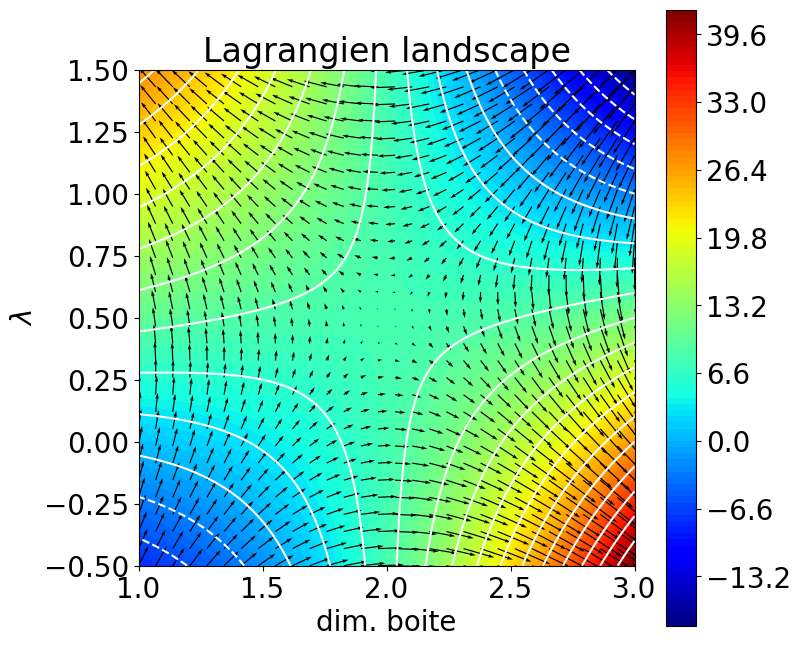

In [57]:
def plot_lagland(fig,ax,model,bounds):
    xmin,xmax,ymin,ymax = bounds
    grid = x0,y0 = np.mgrid[xmin:xmax:101j,ymin:ymax:101j]

    points = np.swapaxes(grid,0,-1).reshape(-1,2)
    v = jax.vmap(lambda p: model(p), in_axes = (0))(points)
    v = np.swapaxes(v.reshape(101,101),0,-1)
    g=ax.contourf(x0,y0,v, levels = 100,cmap='jet')
    fig.colorbar(g,ax=ax)
    ax.contour(x0,y0,v, levels = 20, colors = 'w')

    grid = np.mgrid[xmin:xmax:30j,ymin:ymax:30j]
    points = np.swapaxes(grid,0,-1).reshape(-1,2)
    gradients = jax.vmap(
        jax.grad(
            lambda p: model(p)
        ), in_axes = (0)
    )(points)

    scale = int(10*np.max(gradients))
    ax.quiver(
        points[:,0],
        points[:,1],
        gradients[:,0],
        gradients[:,1],
        angles = 'xy',
#        scale_units='xy',
        scale = scale
    )
    ax.set_aspect("equal")

model = lambda p: Lag(jnp.array([p[0],p[0],p[0],p[1]]))
fig,ax = plt.subplots(1,1,figsize=(8,8))
plot_lagland(fig, ax,model,bounds=(1.,3.,-0.5,1.5))
plt.title("Lagrangien landscape")
plt.xlabel("dim. boite")
plt.ylabel(r"$\lambda$")
plt.show()



# Takeaway message:

- use of jaxopt/optax to do optimization:

    - unconstrained method GradientDescent, optax solver, ScipyMinimize,
    - method with constraint ScipyBoundedMinimize, ProjectedGradient,
    - ScipyRootFinding method to cancel the gradient

- the gradients and Hessian matrix are calculated exactly which consolidates the determination of the parameters and contours.

- Fisher forecast: easy & exact

- several ways to present results (arviz and home-made), loss landscape, gradient-flow